# Machine Translation English-Hindi Example Using SageMaker Seq2Seq

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data Ingestion](#Data-Ingestion)
3. [Training the Machine Translation model](#Training-the-Machine-Translation-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
  4. [Validate the model for use](#Validate-the-model-for-use)
5. [Use a pretrained model](#Use-a-pretrained-model)

## Introduction

Welcome to our Machine Translation end-to-end example! In this demo, we will train a English-Hindi translation model and will test the predictions on a few examples.

IronMan seq2seq algorithm is built on top of [Sockeye](https://github.com/awslabs/sockeye), a sequence-to-sequence framework for Neural Machine Translation based on MXNet. IronMan Seq2Seq implements state-of-the-art encoder-decoder architectures which can also be used for tasks like Abstractive Summarization in addition to Machine Translation.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

1. The credentials and region for the account that's running training. Upload the credentials in the normal AWS credentials file format using the jupyter upload feature. The region must always be `us-west-2` during the Beta program.
2. The roles used to give learning and hosting access to your data. See the documentation for how to specify these.
3. The S3 bucket that you want to use for training and model data.

_Note:_ Credentials for hosted notebooks will be automated before the final release.

In [7]:
import boto3
from time import gmtime, strftime
import time
import numpy as np
import os
import json

# For plotting attention matrix later on
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [24]:
os.environ['AWS_DEFAULT_REGION']='us-west-2'
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = os.getcwd() + '/credentials'

s3_access_role='<<s3 access role>>'
model_role='<<model role>>'

bucket='<<s3 bucket>>' # put your s3 bucket name here, and create s3 bucket
bucket_path = 'https://s3-us-west-2.amazonaws.com/{}'.format(bucket)

# ECS Docker image for SageMaker Seq2Seq.
docker_image = "433757028032.dkr.ecr.us-west-2.amazonaws.com/seq2seq:1"

In [25]:
import urllib.request


def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# English-Hindi dataset
download('https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/recordio/train/train.rec')
download('https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/recordio/validation/val.rec')
download('https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/recordio/vocab/vocab.src.json')
download('https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/recordio/vocab/vocab.trg.json')


upload_to_s3('eng-hindi/train', 'train.rec')
upload_to_s3('eng-hindi/validation', 'val.rec')
upload_to_s3('eng-hindi/vocab', 'vocab.src.json')
upload_to_s3('eng-hindi/vocab', 'vocab.trg.json')

In [ ]:
%%time

job_name = 'translation-eng-hindi-iitb-p2-16x-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": docker_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": s3_access_role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/eng-hindi"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.16xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_seq_len_source": "100",
        "max_seq_len_target": "100",
        "optimized_metric": "bleu",
        "batch_size": "512",
        "checkpoint_frequency_num_batches": "1000",
        "rnn_num_hidden": "512",
        "num_layers_encoder": "2",
        "num_layers_decoder": "2",
        "num_embed_source": "512",
        "num_embed_target": "512",
        "checkpoint_threshold": "2"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 144000
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + '/train',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        },
        {
            "ChannelName": "vocab",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + '/vocab',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + '/validation',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
        }
    ]
}

ease = boto3.Session().client(service_name='sagemaker')
ease.create_training_job(**create_training_params)

status = ease.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(30)
    status = ease.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

In [ ]:
print("""
Now wait for the model artifacts to get uploaded to S3
and proceed to the next step after you see %s folder
in your S3 bucket.""" % job_name)

## Set up hosting for the model

### Skip to [Use a pretrained model](#Use-a-pretrained-model) to play with a pretrained model

In order to set up hosting, we have to import the model from training to hosting. A common question would be, why wouldn't we automatically go from training to hosting? As we worked through examples of what customers were looking to do with hosting, we realized that the Amazon ML model of hosting was unlikely to be sufficient for all customers.

As a result, we have introduced some flexibility with respect to model deployment, with the goal of additional model deployment targets after launch. In the short term, that introduces some complexity, but we are actively working on making that easier for customers, even before GA.

### Import model into hosting
Next, you register the model with hosting. This allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target.

In [ ]:
%%time

sage = boto3.client('sagemaker')

model_name=job_name + '-model'
print(model_name)

info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': docker_image,
    'ModelDataUrl': model_data
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = model_role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

### Create endpoint configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [36]:
from time import gmtime, strftime

endpoint_config_name = 'Seq2SeqEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'p2.xlarge',
        'MaxInstanceCount':1,
        'MinInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Seq2SeqEndpointConfig-2017-11-03-00-27-38
Endpoint Config Arn: arn:aws:im:us-west-2:032969728358:endpoint-config/Seq2SeqEndpointConfig-2017-11-03-00-27-38


### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [47]:
%%time
import time

endpoint_name = 'Seq2SeqEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sage.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sage.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sage.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

Seq2SeqEndpoint-2017-11-03-01-17-43
arn:aws:im:us-west-2:032969728358:endpoint/Seq2SeqEndpoint-2017-11-03-01-17-43
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:im:us-west-2:032969728358:endpoint/Seq2SeqEndpoint-2017-11-03-01-17-43
Status: InService
CPU times: user 64 ms, sys: 12 ms, total: 76 ms
Wall time: 9min 2s


## Validate the model for use
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate predictions from the trained model using that endpoint.

In [48]:
runtime = boto3.Session().client(service_name='sagemaker-runtime') 

In [53]:
%%time
sentences = ["let us dance on the floor !", "do you know how to drive a car ?",
            "you are so awesome !"]

payload = {"instances" : []}
for sent in sentences:
    payload["instances"].append({"data" : sent})

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)
print(response)

[{'target': 'आप कैसे हैं ?'}]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 363 ms


## Use a pretrained model

#### Creating model, endpoint and endpoint config

In [ ]:
%%time
pretrained_model_s3 = "https://s3-us-west-2.amazonaws.com/seq2seq-data/eng-hindi/recordio/translation-eng-hindi-iitb-p2-16x-2017-11-18-04-55-12/output/model.tar.gz"

sage = boto3.client('sagemaker')
model_name = 'EngHindi-'  + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(model_name)

primary_container = {
    'Image': docker_image,
    'ModelDataUrl': pretrained_model_s3
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = model_role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

endpoint_config_name = 'EngHindiEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'p2.xlarge',
        'MaxInstanceCount':1,
        'MinInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

endpoint_name = 'EngHindiEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sage.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sage.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sage.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

In [6]:
runtime = boto3.Session().client(service_name='sagemaker-runtime') 

In [17]:
%%time
sentences = ["let us dance on the floor !", "do you know how to drive a car ?",
            "you are so awesome !"]

payload = {"instances" : []}
for sent in sentences:
    payload["instances"].append({"data" : sent})

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)
print(response)

In [ ]:
response

### Retrieving the Attention Matrix

Passing `"attention_matrix":"true"` in `configuration` of the data instance will return the attention matrix.

In [ ]:
sentence = 'what is your age ?'

payload = {"instances" : [{
                            "data" : sentence,
                            "configuration" : {"attention_matrix":"true"}
                          }
                         ]}

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json.dumps(payload))

response = response["Body"].read().decode("utf-8")
response = json.loads(response)['predictions'][0]

source = sentence
target = response["target"]
attention_matrix = np.array(response["matrix"])

print("Source: %s \nTarget: %s" % (source, target))

In [21]:
# Install the Hindi font for attention matrix
!sudo wget https://cghs.nic.in/mangal.ttf -o /usr/share/fonts/mangal.ttf
hindi_font = FontProperties(fname = 'mangal.ttf')

In [22]:
def plot_matrix(attention_matrix, target, source):
    source_tokens = source.split()
    target_tokens = target.split()
    assert attention_matrix.shape[0] == len(target_tokens)
    plt.imshow(attention_matrix.transpose(), interpolation="nearest", cmap="Greys")
    plt.xlabel("target")
    plt.ylabel("source")
    plt.gca().set_xticks([i for i in range(0, len(target_tokens))])
    plt.gca().set_yticks([i for i in range(0, len(source_tokens))])
    plt.gca().set_xticklabels(target_tokens, fontproperties=hindi_font)
    plt.gca().set_yticklabels(source_tokens)
    plt.tight_layout()

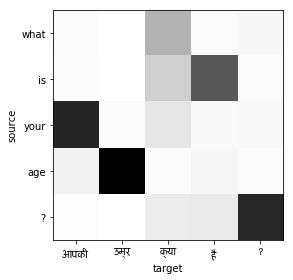

In [23]:
plot_matrix(attention_matrix, target, source)